In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from rxitect.chem.utils import calc_fp
from rxitect.process_qsar_data import load_and_transform

In [2]:
raw_path="../data/raw/ligand_raw.tsv"
# targets=["CHEMBL226", "CHEMBL240", "CHEMBL251"]
targets=["CHEMBL226"]
cols=[
    "target_chembl_id",
    "smiles",
    "pchembl_value",
    "comment",
    "standard_type",
    "standard_relation",
    "document_year",
    ]
px_placeholder=3.99

In [4]:
dataset = load_and_transform(raw_path,
                             targets,
                             cols,
                             px_placeholder)

res = dataset.copy()
X, y = calc_fp(dataset["smiles"]), dataset["pchembl_value"]
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, res.index, test_size=0.2, random_state=42)

Calculating physico-chemical properties: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 389.93it/s]


In [40]:
reg = xgb.XGBRegressor(n_estimators=1_000,
                       tree_method="gpu_hist",
                       gpu_id=0,
                       learning_rate=1-e3,
                       verbosity=3)
cv=5

In [50]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
gs_params = {"learning_rate": learning_rate,}
kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"
sw_train = [1 if px_val>=4 else 0.1 for px_val in y]

gs = GridSearchCV(estimator=reg,
                  param_grid=gs_params,
                  scoring=scoring,
                  return_train_score=True,
                  cv=cv,)

In [52]:
gs.fit(X=X, y=y, sample_weight=sw_train)

[23:17:07] DEBUG: ../src/tree/updater_gpu_hist.cu:817: [GPU Hist]: Configure
[23:17:07] ======== Monitor (0): SketchContainer ========
[23:17:07] MakeCuts: 0.000269s, 1 calls @ 269us

[23:17:07] Prune: 0.000153s, 1 calls @ 153us

[23:17:07] ScanInput: 0.008071s, 1 calls @ 8071us

[23:17:07] Unique: 8.1e-05s, 1 calls @ 81us

[23:17:26] ======== Monitor (0): Learner ========
[23:17:26] Configure: 0s, 1 calls @ 0us

[23:17:26] EvalOneIter: 0.00397s, 1000 calls @ 3970us

[23:17:26] GetGradient: 0.030988s, 1000 calls @ 30988us

[23:17:26] PredictRaw: 0.006534s, 1000 calls @ 6534us

[23:17:26] UpdateOneIter: 18.8543s, 1000 calls @ 18854274us

[23:17:26] ======== Monitor (0): GBTree ========
[23:17:26] BoostNewTrees: 18.9062s, 1000 calls @ 18906156us

[23:17:26] CommitModel: 0.000293s, 1000 calls @ 293us

[23:17:26] ======== Device 0 Memory Allocations:  ========
[23:17:26] Peak memory usage: 228MiB
[23:17:26] Number of allocations: 76922
[23:17:26] ======== Monitor (0): updater_gpu_hist ====

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=0, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.3, max_bin=None,
                                    max_cat_to_...ax_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, ...),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [53]:
gs.cv_results_

{'mean_fit_time': array([19.65994997, 27.77895293, 35.81480975, 32.41370621, 31.78450098,
        31.91960182]),
 'std_fit_time': array([0.92113049, 1.06682618, 0.72838798, 0.29134462, 0.23108366,
        0.3019941 ]),
 'mean_score_time': array([0.00874763, 0.00927191, 0.01090765, 0.01019902, 0.01070228,
        0.01070971]),
 'std_score_time': array([0.00067473, 0.00075993, 0.00079288, 0.00048171, 0.00024251,
        0.00116471]),
 'param_learning_rate': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.0001},
  {'learning_rate': 0.001},
  {'learning_rate': 0.01},
  {'learning_rate': 0.1},
  {'learning_rate': 0.2},
  {'learning_rate': 0.3}],
 'split0_test_score': array([-33.71863854,  -9.83106989,  -3.24453068,  -3.78875211,
         -3.92390319,  -3.89904552]),
 'split1_test_score': array([-31.95791214,  -6.34841355,  -0.75719072,  -

In [54]:
# summarize results
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2.253866 using {'learning_rate': 0.01}
-27.688104 (9.576502) with: {'learning_rate': 0.0001}
-5.844402 (3.175758) with: {'learning_rate': 0.001}
-2.253866 (1.971853) with: {'learning_rate': 0.01}
-2.521063 (1.749861) with: {'learning_rate': 0.1}
-2.614423 (1.612343) with: {'learning_rate': 0.2}
-2.596185 (1.549283) with: {'learning_rate': 0.3}


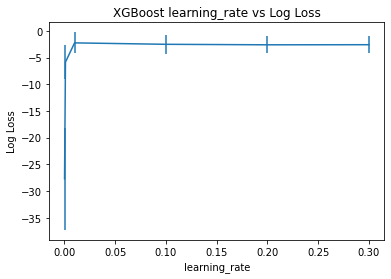

In [66]:
# plot results
plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('learning_rate.png')

In [68]:
xgb_reg = gs.best_estimator_

In [69]:
xgb_reg.score(X_train, y_train, sample_weight=[1 if v>=4 else 0.1 for v in y_train])

0.7193805749459814

In [70]:
preds = xgb_reg.predict(X_test)

In [71]:
y_train.values

array([8.685, 7.   , 9.7  , ..., 5.21 , 6.41 , 8.02 ])

<AxesSubplot:ylabel='pchembl_value'>

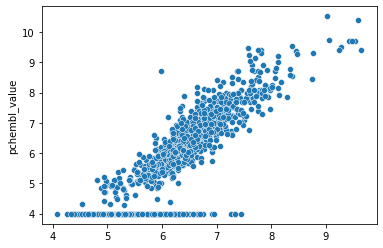

In [72]:
sns.scatterplot(x=preds, y=y_test)

In [75]:
reg_10k = xgb.XGBRegressor(n_estimators=10_000,
                       tree_method="gpu_hist",
                       gpu_id=0,
                       learning_rate=0.01,
                       verbosity=2)

In [77]:
reg_10k.fit(X, y, sample_weight=[1 if v>=4 else 0.1 for v in y])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [78]:
reg_10k.score(X_train, y_train, sample_weight=[1 if v>=4 else 0.1 for v in y_train])

0.9641382796158297

In [85]:
reg_10k.score(X_test, y_test, sample_weight=[1 if v>=4 else 0.1 for v in y_test])

0.9653030358098663

In [80]:
preds_10k = reg_10k.predict(X_test)

<AxesSubplot:ylabel='pchembl_value'>

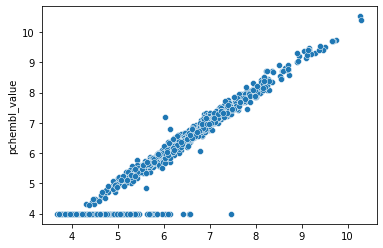

In [83]:
sns.scatterplot(x=preds_10k, y=y_test)

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [113]:
rf_reg = RandomForestRegressor(n_estimators=1_000,
                               n_jobs=-1)

In [121]:
max_features = ["sqrt", "log2", "auto"]
params = {"max_features": max_features}

gs2 = GridSearchCV(rf_reg, param_grid=params, n_jobs=-1, cv=5, return_train_score=True)

In [ ]:
gs2.fit(X, y, sample_weight=[1 if v>=4 else 0.1 for v in y])

In [114]:
cv_result = cross_validate(rf_reg, X_train, y_train,
                            scoring=('r2', 'neg_mean_squared_error'),
                            cv=2,
                            return_estimator=True,
                            return_train_score=True,
                            fit_params={"sample_weight": [1 if v>=4 else 0.1 for v in y_train],},)

In [115]:
cv_result

{'fit_time': array([14.84752321, 15.09788871]),
 'score_time': array([1.60461497, 1.62670207]),
 'estimator': [RandomForestRegressor(max_features='sqrt', n_estimators=10000, n_jobs=-1),
  RandomForestRegressor(max_features='sqrt', n_estimators=10000, n_jobs=-1)],
 'test_r2': array([0.60074654, 0.59289607]),
 'train_r2': array([0.94210992, 0.94476945]),
 'test_neg_mean_squared_error': array([-0.80595563, -0.84810528]),
 'train_neg_mean_squared_error': array([-0.12060037, -0.11149151])}

In [116]:
cvpreds = cv_result["estimator"][0].predict(X_test)

<AxesSubplot:ylabel='pchembl_value'>

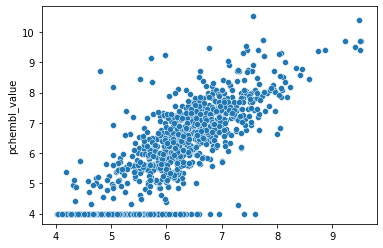

In [117]:
sns.scatterplot(x=cvpreds, y=y_test)

In [120]:
cv_result["estimator"][0].score(X_test, y_test, sample_weight=[1 if v>=4 else 0.1 for v in y_test])

0.5234583541873401